In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gridding Scheme

In [2]:
xedge = 1000
xarea = 10_000

# Reservoir Properties

In [3]:
poro = 0.25
perm = 15

In [4]:
depth = np.array([2059,1559,1059,559.])

In [5]:
pR = 500

# Fluid Properties

In [6]:
visc = 1.0
rho  = 62.4

# Solution

## Reservoir Initialization

In [7]:
p0 = (rho/144*depth).reshape((-1,1)); p0

array([[892.23333333],
       [675.56666667],
       [458.9       ],
       [242.23333333]])

## Numerical Properties

In [8]:
nstep = 50
tstep = 1

## Matrix Construction

In [9]:
conv = 1.06235016e-14*(24*60*60)/1.45e-7

In [10]:
trans = conv*(perm*xarea)/(visc*xedge)

In [11]:
trans

0.9495212464551726

In [12]:
T = np.zeros((4,4))
A = np.zeros((4,4))
J = np.zeros((4,4))
Q = np.zeros((4,1))
G = np.zeros((4,1))

In [13]:
for i in range(4):
  if i==0:
    T[i,i] = trans
    T[i,i+1] = -trans
    G[i,i] = trans*rho/144*xedge*np.sin(30*np.pi/180)
  elif i==3:
    T[i,i] = trans
    T[i,i-1] = -trans
    J[i,i] = 2*trans
    Q[i,0] = 2*trans*pR
  else:
    T[i,i] = 2*trans
    T[i,i+1] = -trans
    T[i,i-1] = -trans
  A[i,i] = xarea*xedge*poro/tstep

In [14]:
T

array([[ 0.94952125, -0.94952125,  0.        ,  0.        ],
       [-0.94952125,  1.89904249, -0.94952125,  0.        ],
       [ 0.        , -0.94952125,  1.89904249, -0.94952125],
       [ 0.        ,  0.        , -0.94952125,  0.94952125]])

In [15]:
A

array([[2500000.,       0.,       0.,       0.],
       [      0., 2500000.,       0.,       0.],
       [      0.,       0., 2500000.,       0.],
       [      0.,       0.,       0., 2500000.]])

In [16]:
J

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.89904249]])

In [17]:
Q

array([[  0.        ],
       [  0.        ],
       [  0.        ],
       [949.52124646]])

In [18]:
G

array([[205.7296034],
       [  0.       ],
       [  0.       ],
       [  0.       ]])

## Setting Total Compressbility

In [19]:
Act = A*1e-5; Act

array([[25.,  0.,  0.,  0.],
       [ 0., 25.,  0.,  0.],
       [ 0.,  0., 25.,  0.],
       [ 0.,  0.,  0., 25.]])

## Explicit Pressure Calculation

In [20]:
def explicit_pressure(P):
    RHS = np.matmul(-(T+J),P)+Q+G
    return P+np.linalg.solve(Act,RHS)

In [21]:
Pn = p0.copy()

EXPLICIT = np.zeros((4,50))

for n in range(nstep):

    Pn = explicit_pressure(Pn)
    
    EXPLICIT[:,n] = Pn.flatten()

## Crank Nicholson Pressure Calculation

In [22]:
def mixed_pressure(P):
    LHS = 0.5*(T+J)+Act
    RHS = np.matmul(Act-0.5*(T+J),P)+Q+G
    return np.linalg.solve(LHS,RHS)

In [23]:
Pn = p0.copy()

MIXED = np.zeros((4,50))

for n in range(nstep):

    Pn = mixed_pressure(Pn)
    
    MIXED[:,n] = Pn.flatten()

## Implicit Pressure Calculation

In [24]:
def implicit_pressure(P):
    LHS = (T+J+Act)
    RHS = np.matmul(Act,P)+Q+G
    return np.linalg.solve(LHS,RHS)

In [25]:
Pn = p0.copy()

IMPLICIT = np.zeros((4,50))

for n in range(nstep):

    Pn = implicit_pressure(Pn)
    
    IMPLICIT[:,n] = Pn.flatten()

# Visualization

In [26]:
EXPLICIT[:,0]

array([892.23333333, 675.56666667, 458.9       , 270.0429116 ])

In [27]:
MIXED[:,0]

array([892.23349763, 675.5754824 , 459.3816869 , 268.55261596])

In [28]:
IMPLICIT[:,0]

array([892.23447587, 675.5978911 , 459.78341616, 267.22845644])

In [29]:
p0

array([[892.23333333],
       [675.56666667],
       [458.9       ],
       [242.23333333]])

In [30]:
xcenter = np.array([500,1500,2500,3500])

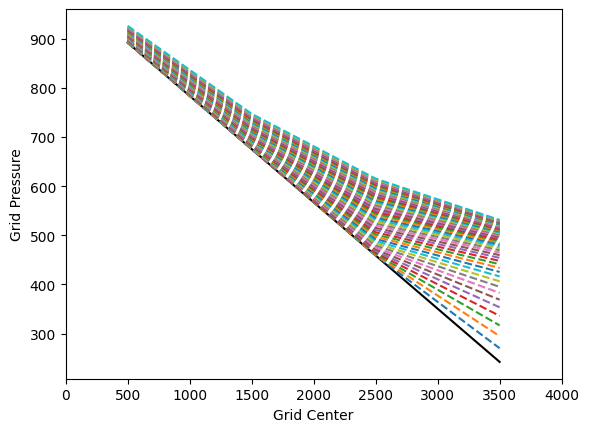

In [31]:
plt.plot(xcenter,p0,'k')

for t in range(nstep):
    plt.plot(xcenter,EXPLICIT[:,t],linestyle='--')

plt.ylabel('Grid Pressure')
plt.xlabel('Grid Center')
plt.xlim((0,4000))

plt.show()

In [32]:
time = np.arange(1,50.5,1); time

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

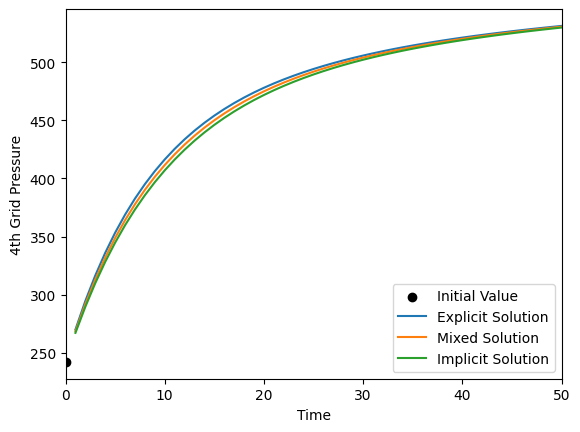

In [33]:
# plt.plot(xcenter,p0,'k')
plt.scatter(0,p0[-1],c='k',label='Initial Value')
plt.plot(time,EXPLICIT[3,:],label='Explicit Solution')
plt.plot(time,MIXED[3,:],label='Mixed Solution')
plt.plot(time,IMPLICIT[3,:],label='Implicit Solution')

plt.ylabel('4th Grid Pressure')
plt.xlabel('Time')

plt.legend()

plt.xlim((0,50))

plt.show()